In [2]:
import numpy as np
import os
from pathlib import Path
from PIL import Image
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms as T
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
# ------------  CONFIG  -------------------
base_path = '/scratch/cv-course-group-5/data/dataset_jpg'
TARGET_SIZE = 224
src_root   = Path(base_path + '/dataset')
dst_root   = Path(base_path + '/preprocessed_dataset')
lmdb_path = Path(base_path + '/lmdb')
anno_file  = Path(base_path + '/dataset/annotations.json')

In [4]:
annos_dict = json.loads(anno_file.read_text())

images = annos_dict.get('images', [])

images

[{'id': 1,
  'video_id': 1,
  'frame_id': 0,
  'width': 1024,
  'height': 1024,
  'file_name': '001/images/xy001c0t001.jpg',
  'num_annotations': 26,
  'cells_alive': 26,
  'dead_cells': 0,
  'divisions': None},
 {'id': 2,
  'video_id': 1,
  'frame_id': 1,
  'width': 1024,
  'height': 1024,
  'file_name': '001/images/xy001c0t002.jpg',
  'num_annotations': 26,
  'cells_alive': 26,
  'dead_cells': 0,
  'divisions': None},
 {'id': 3,
  'video_id': 1,
  'frame_id': 2,
  'width': 1024,
  'height': 1024,
  'file_name': '001/images/xy001c0t003.jpg',
  'num_annotations': 26,
  'cells_alive': 26,
  'dead_cells': 0,
  'divisions': None},
 {'id': 4,
  'video_id': 1,
  'frame_id': 3,
  'width': 1024,
  'height': 1024,
  'file_name': '001/images/xy001c0t004.jpg',
  'num_annotations': 26,
  'cells_alive': 26,
  'dead_cells': 0,
  'divisions': None},
 {'id': 5,
  'video_id': 1,
  'frame_id': 4,
  'width': 1024,
  'height': 1024,
  'file_name': '001/images/xy001c0t005.jpg',
  'num_annotations': 26,
  

In [5]:
json_path = Path('video_lists/train_test_split.json')

# Load the file
with open(json_path, 'r') as f:
    split_data = json.load(f)

# Access the train and test entries
train_list = split_data.get("train", [])
train_list

[{'id': 1, 'name': '001'},
 {'id': 3, 'name': '003'},
 {'id': 4, 'name': '004'},
 {'id': 5, 'name': '005'},
 {'id': 6, 'name': '006'},
 {'id': 8, 'name': '008'},
 {'id': 9, 'name': '009'},
 {'id': 10, 'name': '010'},
 {'id': 11, 'name': '011'},
 {'id': 12, 'name': '012'},
 {'id': 14, 'name': '014'},
 {'id': 19, 'name': '019'},
 {'id': 20, 'name': '020'},
 {'id': 21, 'name': '021'},
 {'id': 22, 'name': '022'},
 {'id': 23, 'name': '023'},
 {'id': 25, 'name': '025'},
 {'id': 26, 'name': '026'},
 {'id': 30, 'name': '030'},
 {'id': 34, 'name': '034'},
 {'id': 35, 'name': '035'},
 {'id': 36, 'name': '036'},
 {'id': 37, 'name': '037'},
 {'id': 38, 'name': '038'},
 {'id': 40, 'name': '040'},
 {'id': 42, 'name': '042'},
 {'id': 43, 'name': '043'},
 {'id': 44, 'name': '044'},
 {'id': 48, 'name': '048'},
 {'id': 49, 'name': '049'},
 {'id': 50, 'name': '050'},
 {'id': 51, 'name': '051'},
 {'id': 53, 'name': '054'},
 {'id': 55, 'name': '056'},
 {'id': 56, 'name': '057'},
 {'id': 57, 'name': '058'},

In [6]:
cells_by_video = {}

for image in images:
    if image['video_id'] in [t['id'] for t in train_list]:
        if image['video_id'] not in cells_by_video:
            cells_by_video[image['video_id']] = {'cells': 0, 'dead_cells': 0, 'cells_alive': 0}
        cells_by_video[image['video_id']]['cells'] += image['cells_alive'] + image['dead_cells']
        cells_by_video[image['video_id']]['dead_cells'] += image['dead_cells']
        cells_by_video[image['video_id']]['cells_alive'] += image['cells_alive']

cells_by_video

{1: {'cells': 5579, 'dead_cells': 99, 'cells_alive': 5480},
 3: {'cells': 6624, 'dead_cells': 96, 'cells_alive': 6528},
 4: {'cells': 3883, 'dead_cells': 32, 'cells_alive': 3851},
 5: {'cells': 4044, 'dead_cells': 14, 'cells_alive': 4030},
 6: {'cells': 4943, 'dead_cells': 91, 'cells_alive': 4852},
 8: {'cells': 3245, 'dead_cells': 16, 'cells_alive': 3229},
 9: {'cells': 4050, 'dead_cells': 86, 'cells_alive': 3964},
 10: {'cells': 3019, 'dead_cells': 39, 'cells_alive': 2980},
 11: {'cells': 5305, 'dead_cells': 88, 'cells_alive': 5217},
 12: {'cells': 6094, 'dead_cells': 115, 'cells_alive': 5979},
 14: {'cells': 3110, 'dead_cells': 52, 'cells_alive': 3058},
 19: {'cells': 4168, 'dead_cells': 69, 'cells_alive': 4099},
 20: {'cells': 4581, 'dead_cells': 57, 'cells_alive': 4524},
 21: {'cells': 1565, 'dead_cells': 37, 'cells_alive': 1528},
 22: {'cells': 2896, 'dead_cells': 44, 'cells_alive': 2852},
 23: {'cells': 4780, 'dead_cells': 70, 'cells_alive': 4710},
 25: {'cells': 3832, 'dead_cel

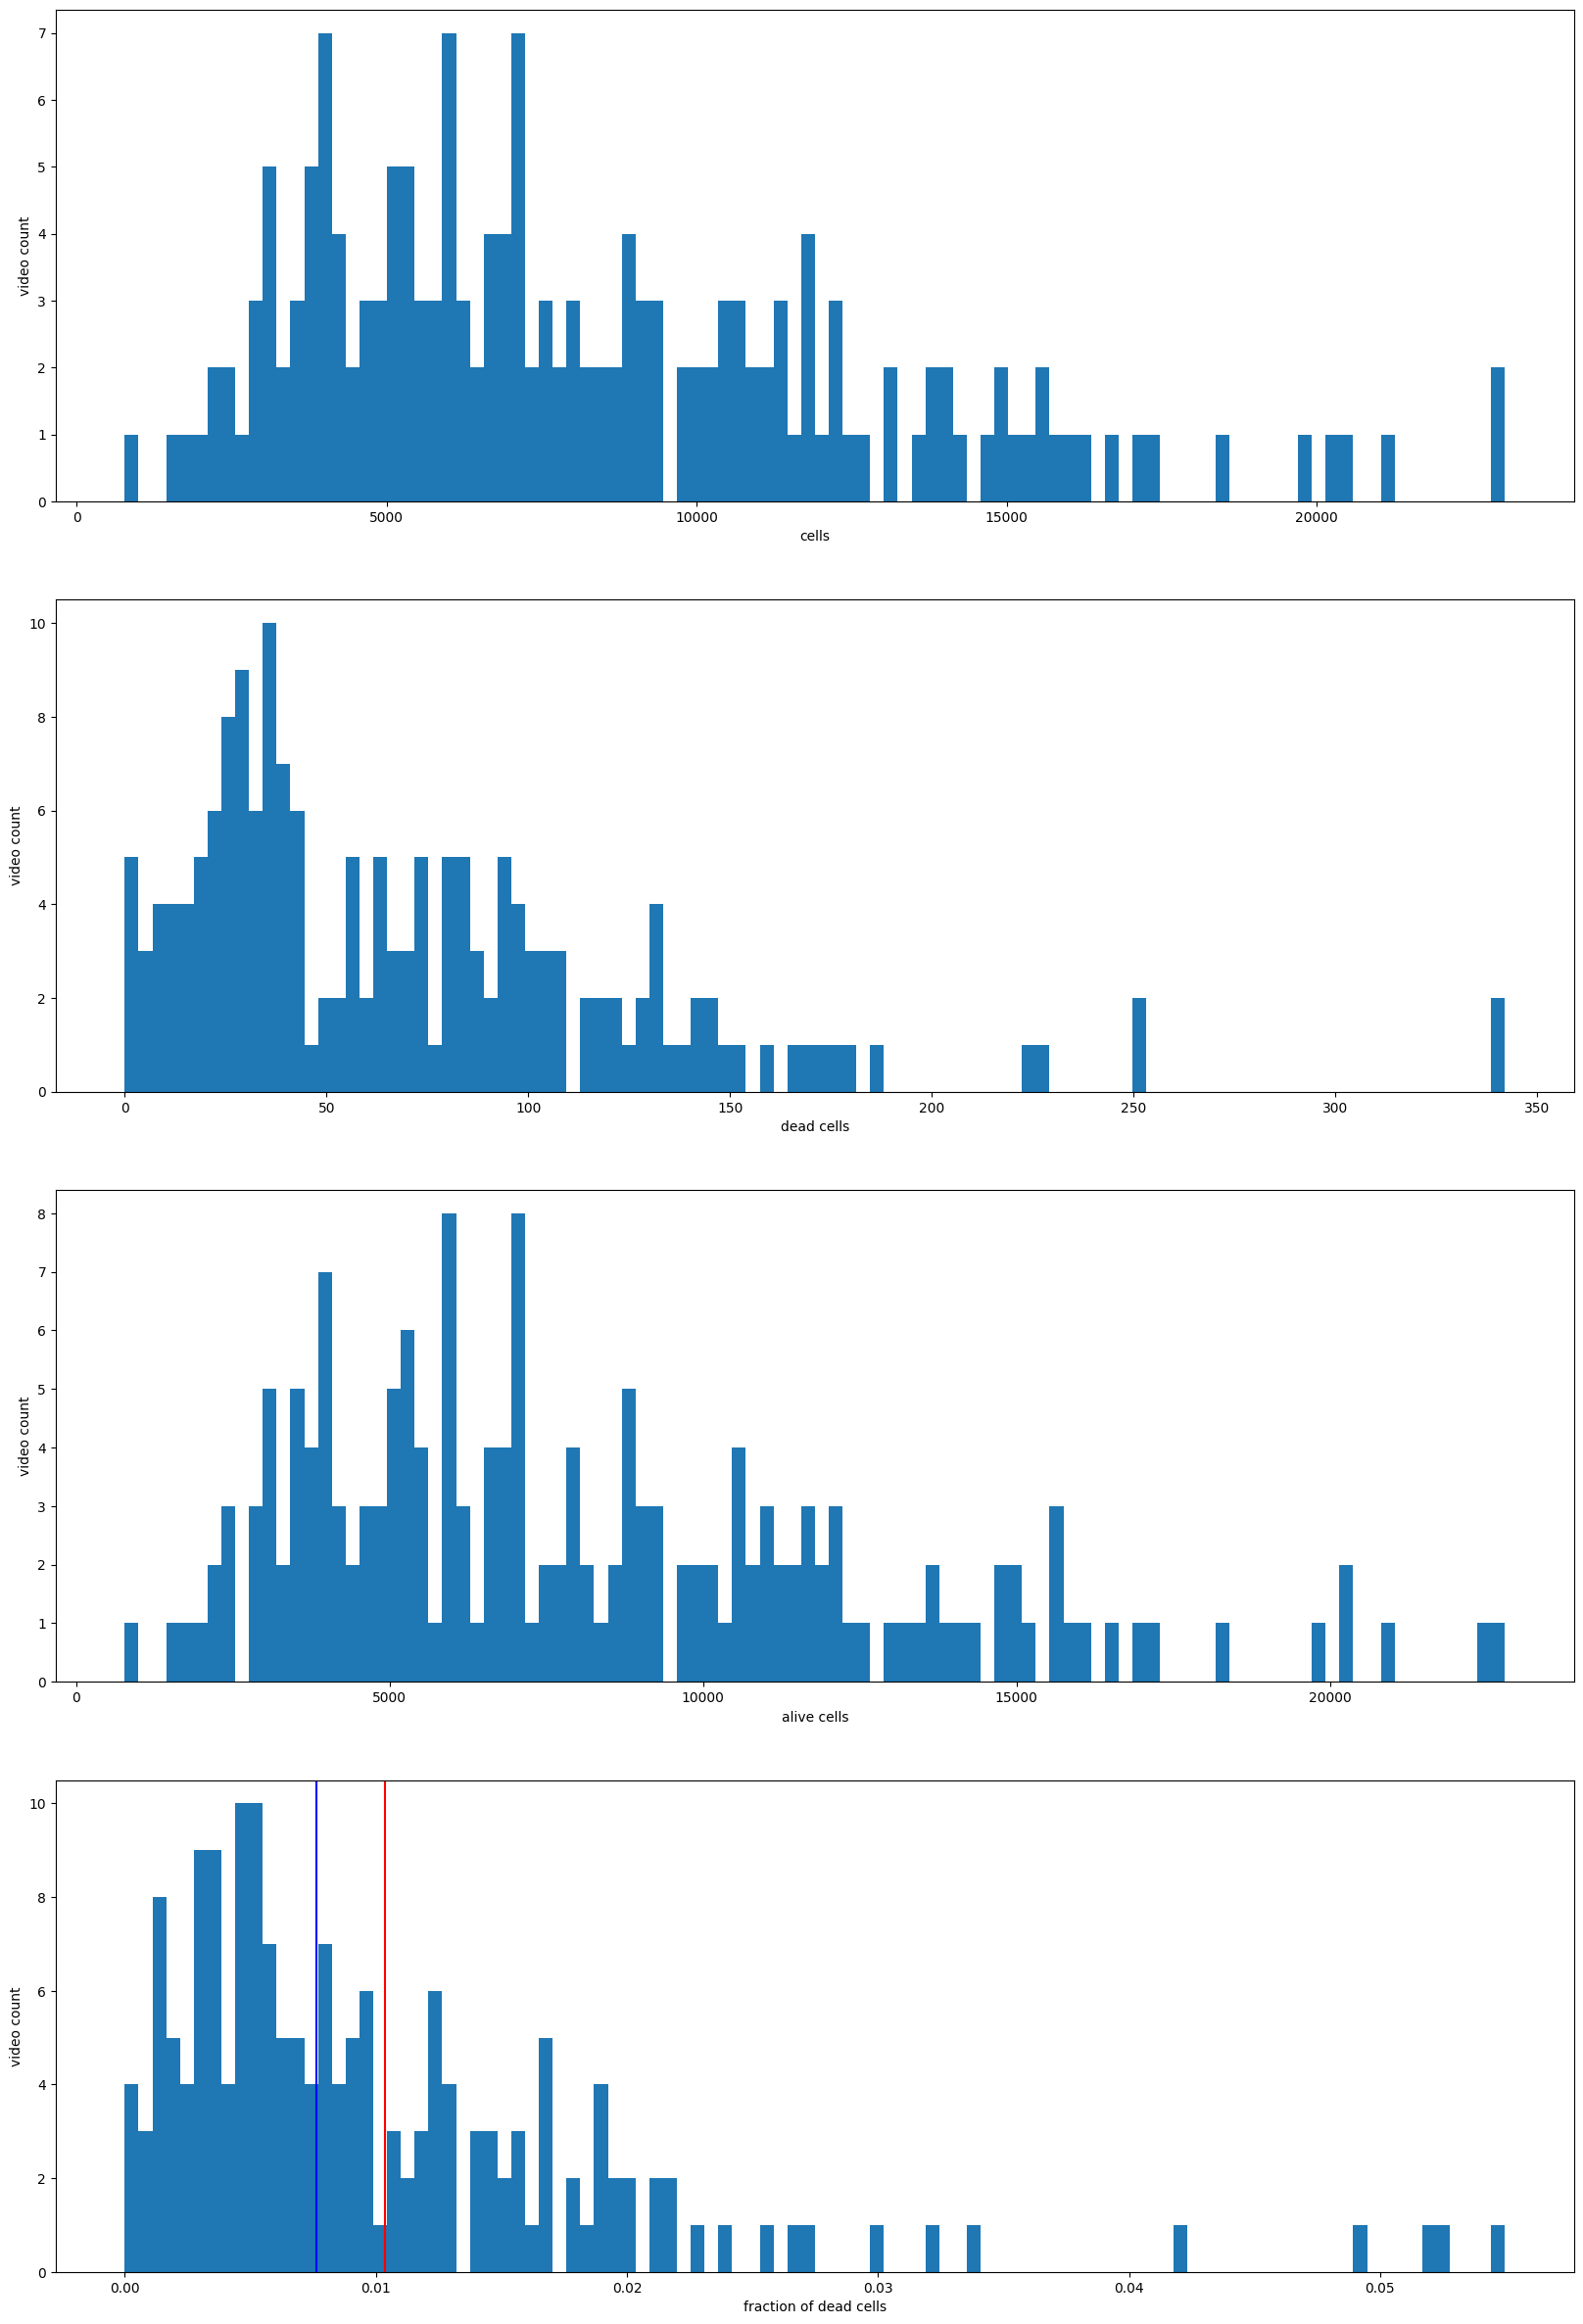

In [7]:
fig, ax = plt.subplots(4)

ax[0].hist([video['cells'] for video in cells_by_video.values()], bins=100)
ax[0].set_xlabel('cells')
ax[0].set_ylabel('video count')
ax[1].hist([video['dead_cells'] for video in cells_by_video.values()], bins=100)
ax[1].set_xlabel('dead cells')
ax[1].set_ylabel('video count')
ax[2].hist([video['cells_alive'] for video in cells_by_video.values()], bins=100)
ax[2].set_xlabel('alive cells')
ax[2].set_ylabel('video count')

fractions_of_dead_cells = np.array([video['dead_cells'] / video['cells'] for video in cells_by_video.values()])
ax[3].hist(fractions_of_dead_cells, bins=100)
ax[3].axvline(np.mean(fractions_of_dead_cells), color='r')
ax[3].axvline(np.median(fractions_of_dead_cells), color='b')
ax[3].set_xlabel('fraction of dead cells')
ax[3].set_ylabel('video count')

fig.set_size_inches(20, 30)
fig.show()

In [8]:

print(f'avg fraction of dead cells: {np.mean(fractions_of_dead_cells)}: ')
print(f'median fraction of dead cells: {np.median(fractions_of_dead_cells)}')

avg fraction of dead cells: 0.01034621004205291: 
median fraction of dead cells: 0.0076289749981116395


In [9]:
import random

cell_count = 0
reduced_videos = []
CELL_THRESHOLD = 400000
random.seed(42)

while cell_count < CELL_THRESHOLD:
    next = train_list.pop(random.randint(0, len(train_list) - 1))
    reduced_videos.append(next)
    cell_count += cells_by_video[next['id']]['cells']

json.dump(reduced_videos, open('video_lists/reduced_videos40k.json', 'w'))